<a href="https://colab.research.google.com/github/andrew-gerlach/small-world-hippos/blob/peter/load_chp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [ ]:
# Data modules
import numpy as np
import cupy as cp
import pandas as pd
import nibabel as nib

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Graph theory modules
import networkx as nx
import community

# Stats modules
import scipy as sc
import statsmodels.api as sm

# python modules
import functools as func
import operator as op
import os


In [ ]:
#pip installs
!pip install nilearn --quiet
from nilearn import plotting, datasets

In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

#NBACK number of frames per run
FRAMES_PER_RUN = 405

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [ ]:
fname = "hcp_rest.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/bqp7m/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = "hcp_covariates.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/x5p4g/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

In [ ]:
# Load github directory for access to Glasser atlas file
!git clone https://github.com/andrew-gerlach/small-world-hippos.git
# Load Glasser atlas
glasser_atlas = nib.load('small-world-hippos/MMP_in_MNI_corr.nii')
img = glasser_atlas.get_fdata()
# Renumber to be continuous from 1 to 360 (right is 1-180, left is 201-380 in original atlas)
for i in range(201,381):
  img[img == i] = i-20
  
# Initialize storage for list of nodes in each network
unique_networks = np.unique(region_info['network'])
nNet = len(unique_networks)          # number of networks
network_regions = {}                 # initialize
for net in unique_networks:
  network_regions[net] = []

# Populate lists and extract node volume
nodeVol = np.zeros(N_PARCELS)
for i in range(N_PARCELS):
  nodeVol[i] = np.sum(img == (i+1))
  network_regions[region_info['network'][i]].append(region_info['name'][i])

We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [ ]:
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

# Helper functions


## Data loading

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

def load_condition(name, mod=np):
  """
  Load all timeseries for a given condition as a 3D numpy array:
    (n_subjects x n_parcels x n_timepoints)
  Possible conditions include "rest", "wm", etc. Can return results as either
  a numpy or cupy array

  Args:
    name (str) : Condition to 
    mod (numpy/cupy module) : Module to use for forming the array
  
  Returns:
    ts (sub x parcels x timepoints) : Array of BOLD datapoints
  """
  assert mod is np or mod is cp, "Use either numpy (np) or cupy (cp) as mod"
  if mod is cp:
    return cp.array([cp.asarray(load_timeseries(subject, name)) for subject in subjects])
  return mod.array([load_timeseries(subject, name) for subject in subjects])
    

## Task-based analysis

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Resting-state analyses

Load a single run of resting-state data:

In [ ]:
help(load_timeseries)

In [ ]:
timeseries = load_timeseries(subject=0, name="rest", runs=1)

Load a concatenated resting-state timeseries (using all runs' data) for each subject:

In [ ]:
timeseries_rest = [load_timeseries(subject, "wm") for subject in subjects]

## Graph Thresholding

Be sure to change the runtime to gpu to speed this up as much as possible! Pass in cupy arrays rather than numpy arrays.

In [ ]:
#@title Threshold Helpers
#@markdown Run this to get the thresholding functions! Main entrypoint is below, 
#@markdown use `help(graph_threshold)` for full description

#@markdown `graph_threshold(input, numSurr)`
def graph_threshold(input, numSurr):
  """
    Thresholds FC data using fourier transform surrogates. Pass in numpy or cupy 
    array. Array must be at least 2 dimensions: the second to last must be nodes
    (e.g. atlas ROI), and the last must be the timecourse. The first
    dimension(s) may be any sort of indexing (e.g. subjects, conditions, etc). 

    Note that using cupy arrays is more than 10 times as fast as using numpy 
    arrays. Be sure to enable GPU in colab.

    Returns array of same type as input array (numpy vs cupy). Shape will 
    be the same as the input, with the exception of the last two dimensions,
    which will contain the thresholded functional connectivity graphs

    Args:
    x (numpy/cupy array of floats with at least 2 dims): data to be thresholded
    numSurr (scalar): Number of surrogates to calculate

    Returns:
    (numpy/cupy array of floats) : Functional connectivity graphs 
  """
  xp = cp.get_array_module(input)
  index_dims = input.shape[:-2]
  if len(index_dims) > 1:
    # We put the single number inside a tuple
    index_dims = ( func.reduce(op.mul, input.shape[:-2]) )
  elif len(index_dims) == 0:
    index_dims = ( 1, )
  # Here, if index_dims is an empty tuple, it will not contribute anything to
  # the shape (i.e. working_shape will be a 2d tuple)
  shape = (*index_dims, *input.shape[-2:])
  working_input = xp.reshape(input, shape)
  results = xp.empty((*index_dims, *corrcoef_shape(input)))
  for i, sample in enumerate(working_input):
    results[i] = surrogate_threshold(sample, numSurr)
  
  return xp.reshape(results, (*input.shape[:-2], *corrcoef_shape(input)))


def surrogate_threshold(input, numSurr):
  xp = cp.get_array_module(input)
  assert(len(input.shape) == 2)
  fc_surr = xp.empty((numSurr, *corrcoef_shape(input)))
  for i in range(numSurr):
    surr = phase_randomize(input)
    fc_surr[i] = xp.corrcoef(surr)

  fc = xp.corrcoef(input)
  cp.cuda.Device().synchronize()

  if xp is cp:
    fc = cp.asnumpy(fc)
    fc_surr = cp.asnumpy(fc_surr)
  pvals = sc.stats.mstats.ttest_1samp(fc_surr, fc, axis=0).pvalue
  reject = two_d_multipletest(pvals)
  fc[~reject] = 0
  if xp is cp:
    fc = cp.asarray(fc)
  return fc


def two_d_multipletest(pvals, method='fdr_bh'):
  reject = sm.stats.multipletests(np.reshape(pvals, -1), method=method)[0]
  return np.reshape(reject, pvals.shape)


def phase_randomize(input):
  xp = cp.get_array_module(input)
  f_len = input.shape[-1]
  # 1. Calculate the Fourier transform of the original signal.
  f_transform = xp.fft.fft(input, f_len, axis=-1)
  amplitudes = np.abs(f_transform)

  # 2. Generate a vector of random phases (i.e. a random sequence of values in
  #    the range [0, 2pi]) , with length L/2 , where L is the length of the time
  #    series.
  #    In this implementation, we make phases the same length as the transform,
  #    then symmetrize the phases by setting the front half as equal to the 
  #    negative of the back half.
  phases = xp.random.uniform(-xp.pi, xp.pi, input.shape)
  phases[..., f_len//2:] = -phases[..., f_len//2:0:-1]
  phases[..., 0] = 0

  # 3. As the Fourier transform is symmetrical, to create the new phase 
  #    randomized vector, multiply the first half of F (i.e. the half
  #    corresponding to the positive frequencies) by the phases to create the
  #    first half of F_r. The remainder of F_r is then the horizontally flipped
  #    complex conjugate of the first half. 

  phases_added = amplitudes * xp.exp(1j * phases)


  # 4. Finally, the inverse Fourier transform F_r of gives the FT surrogate. 
  #    Specifying time_len (the length of our original matrix) automatically
  #    pads the input array with 2 0s in each trial (as a result of the above
  #    operations, the array has 2 fewer timepoints than our input)
  return xp.real(xp.fft.ifft(phases_added, f_len))

def corrcoef_shape(a):
  assert(len(a.shape) > 1)
  return (a.shape[-2], a.shape[-2])

In [ ]:
#times = load_condition('rest', cp)

group_fc = cp.asnumpy(graph_threshold(times, 2).mean(axis=0))



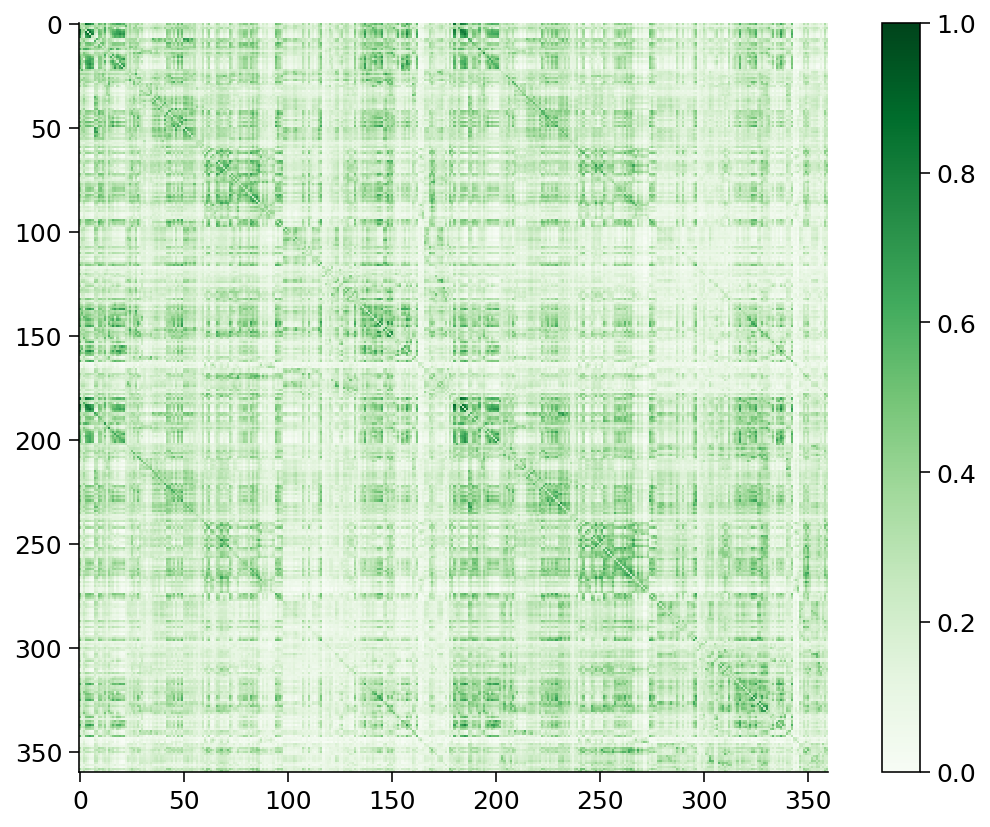

In [ ]:
pd_mean = pd.DataFrame(group_fc)
plt.imshow(pd_mean, interpolation="none", cmap="Greens", vmin=0, vmax=1)
plt.colorbar()
plt.show()

## Graph Theory

This is a work in progress :)

In [ ]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef( ts)

group_fc = fc.mean(axis=0)
group_fc_nan = np.copy(group_fc)
np.fill_diagonal(group_fc_nan, np.nan)

fc_matrix = pd.DataFrame(group_fc_nan)
fc_matrix.columns = region_info["name"]
fc_matrix.index = region_info["name"]
fc_matrix = fc_matrix.sort_index(0).sort_index(0)

plt.imshow(fc_matrix, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
group_fc = abs(group_fc)
group_fc_nan = abs(group_fc_nan)

In [ ]:
bins = np.arange(np.sqrt(len(np.concatenate(group_fc))))
bins = (bins - np.min(bins))/np.ptp(bins)
fig, axes = plt.subplots(1,2, figsize=(15,5))

rawdist = sns.distplot(group_fc_nan.flatten(), bins=bins, kde=False, ax=axes[0], norm_hist=True)
rawdist.set(xlabel='Correlation Values', ylabel = 'Density Frequency')

log10dist = sns.distplot(np.log10(group_fc_nan).flatten(), kde=False, ax=axes[1], norm_hist=True)
log10dist.set(xlabel='log(weights)')

In [ ]:
from collections import defaultdict

def make_subgraphs(np_matrix, region_info):
  network_members = defaultdict(list)
  for net, name in zip(region_info["network"], region_info["name"]):
    network_members[net].append(name)


class FC_graph:

  # Nodal properties
  WEIGHT = "weight"
  STRENGTH = "strength"
  STRENGTHNORM = "strengthnorm"
  DISTANCE = "distance"
  CLOSENESS = "closeness"
  
  def __init__(self, np_matrix, region_info):
    self.data = np_matrix
    self.G = self._prepare_graph(np_matrix, region_info["name"])
    self.region_info = region_info
    self.names = self.region_info["name"]
    self.networks = self.region_info["network"]

    # Compute subgraphs
    network_members = defaultdict(list)
    for net, name in zip(region_info["network"], region_info["name"]):
      network_members[net].append(name)
    self.sub_G = { net: self.G.subgraph(members).copy()
                     for net, members in network_members.items() }

    self._compute_graph_attributes(self.G)
    [self._compute_graph_attributes(G) for G in self.sub_G.values()]

  def _prepare_graph(self, np_matrix, names):
    G = nx.from_numpy_matrix(np_matrix)
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    G = nx.relabel_nodes(G, dict(enumerate(names)))

  def _compute_graph_attributes(self, G):
    self._compute_degree(G)
    self._compute_distance(G)

  def _compute_degree(self, G):
    strength = G.degree(weight=self.WEIGHT)
    strengths = dict(strength)
    nx.set_node_attributes(G, strengths, self.STRENGTH) # Add as nodal attribute

    # Normalized node strength values 1/N-1
    normstrenghts = {node: val * 1/(len(G.nodes)-1) for (node, val) in strength}
    nx.set_node_attributes(G, normstrenghts, self.STRENGTHNORM)
  
  def _compute_distance(self, G):
    # The function accepts a argument 'distance' that, in correlation-based 
    # networks, must be seen as the inverse of the weight value. Thus, a high
    # correlation value (e.g., 0.8) means a shorter distance (i.e., 0.2).
    G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data=self.WEIGHT)}

    # Then add them as attributes to the graph edges
    nx.set_edge_attributes(self.G, G_distance_dict, self.DISTANCE)


  def _node_subnet(self, node):
    return dict(zip(self.names, self.networks))[node]

  def get_subgraphs(self, region_info):
    network_members = defaultdict(list)
    for net, name in zip(region_info["network"], region_info["name"]):
      network_members[net].append(name)

    names = np.array(region_info["name"])
    for region in network_members:
      indices = np.where(names in )
    
    return = { net: self.G.subgraph(members).copy()
                     for net, members in network_members.items() }



  def node_degree(self, node, subnet=False):
    G = self._node_subnet(node) if subnet else self.G
    return nx.get_node_attributes(G, self.STRENGTHNORM)[node]

  def mean_degree(self, subnet=None):
    G = subnet if subnet else self.G
    strengths = nx.get_node_attributes(G, self.STRENGTHNORM).values()
    normstrengthlist = np.array(list(strengths))
    return np.sum(normstrengthlist)/len(G.nodes)

  def sparser_graph(self, threshold):
    new_matrix = self.data.copy()
    new_matrix[new_matrix<=threshold] = 0
    return FC_graph(new_matrix, self.region_info)

  def closeness_centrality(self, node):
    

    # Computation of Closeness Centrality
    closeness = nx.closeness_centrality(G, distance='distance')

    # Now we add the closeness centrality value as an attribute to the nodes
    nx.set_node_attributes(self.G, closeness, self.CLOSENESS)

    # Closeness Centrality Histogram
    sns.distplot(list(closeness.values()), kde=False, norm_hist=False)
    plt.xlabel('Centrality Values')
    plt.ylabel('Counts')

  def betweenness_centrality(self):
    betweenness = nx.betweenness_centrality(self.G, weight='distance', normalized=True) 

In [ ]:
from collections import defaultdict
def get_subgraphs(region_info):
  network_members = defaultdict(list)
  for net, name in zip(region_info["network"], region_info["name"]):
    network_members[net].append(name)

  names = region_info["name"]
  print(network_members)
  for region, subnet in network_members.items():
    np.array([name in subnet for name in names]).nonzero()
  
get_subgraphs(region_info)

defaultdict(<class 'list'>, {'Visual1': ['R_V1', 'R_ProS', 'R_DVT', 'L_V1', 'L_ProS', 'L_DVT'], 'Visual2': ['R_MST', 'R_V6', 'R_V2', 'R_V3', 'R_V4', 'R_V8', 'R_V3A', 'R_V7', 'R_IPS1', 'R_FFC', 'R_V3B', 'R_LO1', 'R_LO2', 'R_PIT', 'R_MT', 'R_LIPv', 'R_VIP', 'R_PH', 'R_V6A', 'R_VMV1', 'R_VMV3', 'R_V4t', 'R_FST', 'R_V3CD', 'R_LO3', 'R_VMV2', 'R_VVC', 'L_MST', 'L_V6', 'L_V2', 'L_V3', 'L_V4', 'L_V8', 'L_V3A', 'L_V7', 'L_IPS1', 'L_FFC', 'L_V3B', 'L_LO1', 'L_LO2', 'L_PIT', 'L_MT', 'L_LIPv', 'L_VIP', 'L_PH', 'L_V6A', 'L_VMV1', 'L_VMV3', 'L_V4t', 'L_FST', 'L_V3CD', 'L_LO3', 'L_VMV2', 'L_VVC'], 'Somatomotor': ['R_4', 'R_3b', 'R_5m', 'R_5L', 'R_24dd', 'R_24dv', 'R_7AL', 'R_7PC', 'R_1', 'R_2', 'R_3a', 'R_6d', 'R_6mp', 'R_6v', 'R_OP4', 'R_OP1', 'R_OP2-3', 'R_FOP2', 'R_Ig', 'L_4', 'L_3b', 'L_5m', 'L_5L', 'L_24dd', 'L_24dv', 'L_7AL', 'L_7PC', 'L_1', 'L_2', 'L_3a', 'L_6d', 'L_6mp', 'L_6v', 'L_OP4', 'L_OP1', 'L_OP2-3', 'L_RI', 'L_FOP2', 'L_Ig'], 'Cingulo-Oper': ['R_FEF', 'R_5mv', 'R_23c', 'R_SCEF', 'R_6

In [ ]:
fc_G = FC_graph(group_fc, region_info)

fc_G.mean_degree()

In [ ]:
G = nx.from_numpy_matrix(group_fc)
G.remove_edges_from(list(nx.selfloop_edges(G)))
G = nx.relabel_nodes(G, dict(enumerate(region_info["name"])))
print(G.nodes)

In [ ]:
# Betweenness centrality:
#print(nx.betweenness_centrality.__doc__)
betweenness = nx.betweenness_centrality(G, weight='distance', normalized=True) 
                                                              

In [ ]:
# Now we add the it as an attribute to the nodes
#nx.set_node_attributes(G, betweenness, 'bc')

# Visualise  values directly
#print(betweenness)

# Betweenness centrality Histogram
sns.distplot(list(betweenness.values()), kde=False)
plt.xlabel('Centrality Values')
plt.ylabel('Counts')

In [ ]:
# Path Length
#print(nx.shortest_path_length.__doc__)

# This is a versatile version of the ones below in which one can define or not source and target. Remove the hashtag to use this version.
#list(nx.shortest_path_length(G, weight='distance'))

# This one can also be used if defining source and target: 
#print(nx.dijkstra_path_length.__doc__)
#nx.dijkstra_path_length(G, source=20, target=25, weight='distance')

# Whereas this one is for all pairs. Remove the hashtag to use this version.
#print(nx.all_pairs_dijkstra_path_length.__doc__)
list(nx.all_pairs_dijkstra_path_length(G, weight='distance'))

In [ ]:
# Average Path Length or Characteristic Path Length
#print(nx.average_shortest_path_length.__doc__)
nx.average_shortest_path_length(G, weight='distance')

In [ ]:
# Modularity
#print(community.best_partition.__doc__)
#from community import best_partition
part = community.best_partition(G, weight='weight')

# Visualise values directly
#print(part)

# Check the number of communities
set(part.values()).union()

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

In [ ]:
fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

group_fc = fc.mean(axis=0)

plt.imshow(group_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

Plot the profile of FC values between a particular "seed" parcel and every parcel in the dataset, separated by hemisphere:

In [ ]:
seed_roi = "R_9-46d"  # name of seed parcel
seed_idx = region_info["name"].index(seed_roi)

hemi_fc = np.split(group_fc, 2)

# Plot the FC profile across the right and left hemisphere target regions
for i, hemi_fc in enumerate(hemi_fc):
  plt.plot(hemi_fc[:, seed_idx], label=f"{HEMIS[i]} hemisphere")
plt.title(f"FC for region {seed_roi}")
plt.xlabel("Target region")
plt.ylabel("Correlation (FC)")
plt.legend()
plt.show()

Threshold the correlation matrix to produce a connectome, and plot it:

In [ ]:
plotting.view_connectome(group_fc, atlas["coords"], edge_threshold="99%")

ACTUAL PROJECT WORK
Calculate the node-wise functional connectivity summary features

In [ ]:
# Node-to-node connectivity
def extract_connectivities(seed_rois, target_rois, fc, nSubj):
  fc_summary = np.zeros((N_SUBJECTS,len(seed_rois),len(target_rois)))
  for i_seed in range(len(seed_rois)):
    seed_idx = region_info["name"].index(seed_rois[i_seed])
    for i_target in range(len(target_rois)):
      target_idx = region_info["name"].index(target_rois[i_target])
      if target_idx == seed_idx:
        continue 
      for i_subj in range(nSubj):
        fc_summary[i_subj,i_seed,i_target] = fc[i_subj,seed_idx,target_idx]

  return fc_summary

# example to calculate right dlPFC to DAN
seed_rois = ["R_9-46d"]
target_rois = network_regions['Dorsal-atten']
fc_n2n = extract_connectivities(seed_rois, target_rois, fc, N_SUBJECTS)
fc_dlPFC_to_DAN = fc_n2n.mean(axis=2)    # average over all target nodes


# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Load individual runs for a given task

In [ ]:
print(os.listdir(f"{HCP_DIR}/subjects/128/EVs/tfMRI_WM_RL/"))
!cat ./hcp/subjects/128/EVs/tfMRI_WM_RL/2bk_body.txt

Load working memory data for each subject

In [ ]:
task = "wm"
conds = {'0bk': ["0bk_body", "0bk_faces", "0bk_places", "0bk_tools"],
         '2bk': ["2bk_body", "2bk_faces", "2bk_places", "2bk_tools"]}

N_CONDS = len(conds['2bk'])
BLOCK_FRAMES = int(27.5/TR) # 27.5s is the duration of each block

# intialize
timeseries_task_wm = {}
for l in ('0bk','2bk'):
  timeseries_task_wm[l] = []

for subject in range(N_SUBJECTS):

  # Load full timeseries
  timeseries = load_timeseries(subject=subject, name=task) # this is a 360, 810 numpy.ndarray
  # Extract 2back timepoints 
  for l in ('0bk','2bk'):
    evs = [load_evs(subject, task, cond) for cond in conds[l]]
    ## Notes: evs is a list of 4 (sub)lists - 1 per condition
    # Each sublist contains 2 dictionaries - 1 per run
    # Each dictionary contains onset, duration, and amplitude keys

    ts_block = np.zeros((N_PARCELS, N_CONDS*N_RUNS_TASK*BLOCK_FRAMES))
    for i in range(N_CONDS):
      for j in range(N_RUNS_TASK):
        onset_frames = int(evs[i][j]["onset"]/TR) + j*FRAMES_PER_RUN
        ts_block[:,(i*N_RUNS_TASK+j)*BLOCK_FRAMES:(i*N_RUNS_TASK+j + 1)*BLOCK_FRAMES] = timeseries[:,onset_frames:onset_frames+BLOCK_FRAMES]

    # Concat new timeseries into timeseries_task_wm_2back

    timeseries_task_wm[l].append(ts_block)

Load each subject's data for a specific task, separately for each run:

In [ ]:
timeseries_task = []
for subject in subjects:
  timeseries_task.append(load_timeseries(subject, "motor", concat=False))

## Run a simple subtraction analysis

In [ ]:
help(load_evs)

In [ ]:
help(selective_average)

In [ ]:
task = "motor"
conditions = ["lf", "rf"]  # Run a substraction analysis between two conditions

contrast = []
for subject in subjects:

  # Get the average signal in each region for each condition
  evs = [load_evs(subject, task, cond) for cond in conditions]
  avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

  # Store the region-wise difference
  contrast.append(avgs[0] - avgs[1])

group_contrast = np.mean(contrast, axis=0)

Plot group-averaged contrast value across regions:

In [ ]:
hemi_contrasts = np.split(group_contrast, 2)

for i, hemi_contrast in enumerate(hemi_contrasts):
  plt.plot(hemi_contrast, label=f"{HEMIS[i]} hemisphere")

plt.title("Contrast of %s - %s" % (conditions[0], conditions[1]))
plt.xlabel("Region")
plt.ylabel('Contrast')
plt.legend()
plt.show()

Plot the regional values on the surface of one hemisphere:

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = group_contrast[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast,
                   vmax=15)

## Characterize values by functional network

Average the contrast values within parcels belonging to each network and plot:

In [ ]:
# Get unique network labels
network_names = np.unique(region_info["network"])

hemi_networks = np.split(region_info["network"], 2)
hemi_contrasts = np.split(group_contrast, 2)

# Get and plot mean contrast value per network, by hemisphere
for hemi, hemi_network, hemi_contrast in zip(HEMIS, hemi_networks, hemi_contrasts):
  network_vals = []
  for network in network_names:
    network_vals.append(hemi_contrast[hemi_network == network].mean())
  plt.barh(network_names, network_vals, alpha=.5, label=f"{hemi} hemi")

plt.axvline(0)
plt.xlabel("Amplitude difference")
plt.title(f"Contrast of {conditions[0]} - {conditions[1]}")
plt.legend()
plt.show()

# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [ ]:
wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
print(wm_behavior[:5])
print(wm_behavior.dtype.names)

In [ ]:
import pandas as  pd

wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")
#print(wm_behavior[:5])
#print(wm_behavior.dtype.names)

# Make separate dataframes for 0 and 2 back performance measures
back0_array = (wm_behavior[np.where((wm_behavior["ConditionName"] == "0BK_BODY") | (wm_behavior["ConditionName"] == "0BK_FACE") | (wm_behavior["ConditionName"] == "0BK_TOOL") | (wm_behavior["ConditionName"] == "0BK_PLACE"))])
back2_array = (wm_behavior[np.where((wm_behavior["ConditionName"] == "2BK_BODY") | (wm_behavior["ConditionName"] == "2BK_FACE") | (wm_behavior["ConditionName"] == "2BK_TOOL") | (wm_behavior["ConditionName"] == "2BK_PLACE"))])
back0_df = pd.DataFrame(back0_array)
back2_df = pd.DataFrame(back2_array)

# Make dataframes with 1 performance score per subject (averaged across runs)
back0_mean = back0_df.groupby('Subject').mean()
back2_mean = back2_df.groupby('Subject').mean()

# Concat 0 and 2 back dataframes
wm_behavior_byBlock = pd.concat([back0_mean, back2_mean], keys=['0back', '2back'])

# Average by subject and run
#back0_df.groupby(['Subject', 'Run']).mean()
#back2_df.groupby(['Subject', 'Run']).mean()

# Accuracy Mean and standard deviation 
print("0 back Accuracy; mean SD")
print(round(back0_mean["ACC"].mean(), 2), round(back0_mean["ACC"].std(),2 ))
print("2 back Accuracy; mean SD")
print(round(back2_mean["ACC"].mean(),2), round(back2_mean["ACC"].std(),2))

# RT Mean and standard deviation 
print("0 back MEDIAN_RT; mean SD")
print(round(back0_mean["MEDIAN_RT"].mean(), 2), round(back0_mean["MEDIAN_RT"].std(),2 ))
print("2 back MEDIAN_RT; mean SD")
print(round(back2_mean["MEDIAN_RT"].mean(), 2), round(back2_mean["MEDIAN_RT"].std(),2 ))

# Histograms
#back0_mean.hist(bins=20)
#back2_mean.hist(bins=20)
hist_acc_0 = back0_mean["ACC"].hist(bins=20, color = "blue", alpha=0.3)
hist_acc_2 = back2_mean["ACC"].hist(bins=20, color = "red", alpha=0.3)

hist_rt_0 = back0_mean["MEDIAN_RT"].hist(bins=20, color = "green", alpha=0.3)
hist_rt_2 = back2_mean["MEDIAN_RT"].hist(bins=20, color = "yellow", alpha=0.3)




But, while not formally taught as part of the course, [`pandas`](https://pandas.pydata.org/) offers more powerful tools for tabular data analysis.

## Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [ ]:
demo = np.load("hcp/pseudo_demographics.npy")
demo.shape

## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [ ]:
ids = np.loadtxt("hcp/orig_ids.txt")
print(ids[:8])